# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Цель:** Обучить модель классифицировать комментарии на позитивные и негативные. Построить модель со значением метрики качества *F1* не меньше 0.75.

**Задачи**
1. Загрузить и подготовить данные.
2. Обучить разные модели.
3. Сделайть выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>План проекта<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Анализ-датафрейма" data-toc-modified-id="Анализ-датафрейма-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ датафрейма</a></span><ul class="toc-item"><li><span><a href="#Проверка-на-наличие-пропущенных-значений-и-дубликатов" data-toc-modified-id="Проверка-на-наличие-пропущенных-значений-и-дубликатов-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Проверка на наличие пропущенных значений и дубликатов</a></span></li></ul></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></div>

## Загрузка данных

In [ ]:
!/opt/conda/bin/python -m pip install wordcloud==1.8.2.2 -q

In [ ]:
import pandas as pd
import re
import spacy
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from wordcloud import WordCloud

nlp = spacy.load('en_core_web_sm')
RANDOM_STATE = 42
TEST_SIZE=0.2

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


## Анализ датафрейма

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


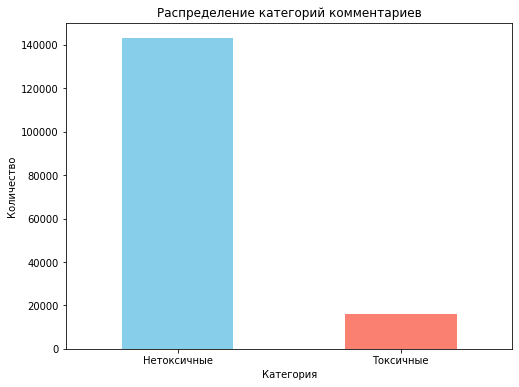

In [ ]:
df['toxic'] = df['toxic'].astype('category')
df['toxic'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'], figsize=(8, 6))
plt.title('Распределение категорий комментариев')
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.xticks(ticks=[0, 1], labels=['Нетоксичные', 'Токсичные'], rotation=0)
plt.show()

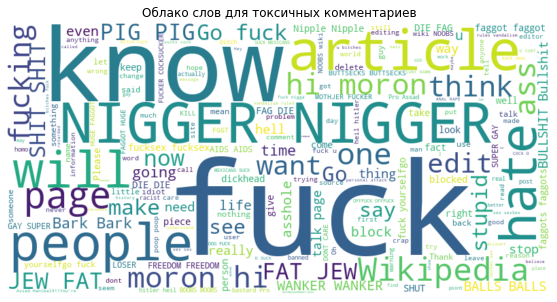

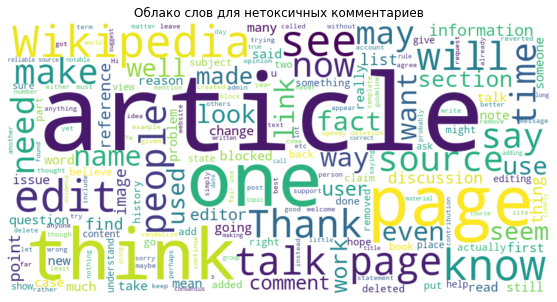

In [ ]:
toxic_comments = df[df['toxic'] == 1]['text']
nontoxic_comments = df[df['toxic'] == 0]['text']
toxic_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(toxic_comments))
plt.figure(figsize=(10, 5))
plt.imshow(toxic_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для токсичных комментариев')
plt.show()

nontoxic_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(nontoxic_comments))
plt.figure(figsize=(10, 5))
plt.imshow(nontoxic_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для нетоксичных комментариев')
plt.show()

### Проверка на наличие пропущенных значений и дубликатов

In [ ]:
print(df.isnull().sum())
print(df.duplicated().sum())

text     0
toxic    0
dtype: int64
0


## Подготовка данных

In [ ]:
def preprocess_text(text):
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text.lower())
    text = text.strip()
    return text

In [ ]:
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return ' '.join(lemmatized_words)

In [ ]:
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns=['text'])

df_my['processed_text'] = df_my['text'].apply(preprocess_text).apply(lemmatize_text)
print(df_my)

                                                text  \
0  The striped bats are hanging on their feet for...   
1      you should be ashamed of yourself went worked   

              processed_text  
0  stripe bat hang foot good  
1            ashamed go work  


Функция работает корректно

In [ ]:
df.head(3)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0


In [ ]:
data = df.copy()
data['text'] = data['text'].apply(preprocess_text).apply(lemmatize_text)
data.head(3)

,text,toxic
0,explanation edit username hardcore metallica f...,0
1,d aww match background colour m seemingly stuc...,0
2,hey man m try edit war s guy constantly remove...,0


In [ ]:
X = data['text']
y = data['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)

## Обучение

Поскольку в данном случае решается задача классификации, выберем несколько моделей, которые подходят для этой задачи. В нашем случае это LogisticRegression и RandomForestClassifier. При обучении моделей затрачивается довольно много ресурсов, поэтому подбор гиперпараметров будет ограничен.

In [ ]:
param_grids = {
    'Logistic Regression': {
        'tfidf__ngram_range': [(1, 1)],
        'clf__C': [0.1, 1, 10],
        'clf__penalty': ['l1', 'l2'],
        'clf__solver': ['saga']
    },
    'Random Forest': {
        'tfidf__ngram_range': [(1, 1)],
        'clf__n_estimators': [50, 100],
        'clf__max_depth': [10, 20]
    }}
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2500, max_df=0.75)),
    ('clf', LogisticRegression(random_state=RANDOM_STATE))
])
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2500, max_df=0.75)),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

In [ ]:
grid_search_lr = GridSearchCV(pipeline_lr,
                              param_grids['Logistic Regression'],
                              cv=5,
                              scoring='f1',
                              n_jobs=-1,
                              verbose=1)

grid_search_lr.fit(X_train, y_train)

best_model_lr = grid_search_lr.best_estimator_

print(f'Лучшие параметры для Logistic Regression: {grid_search_lr.best_params_}')
print(f'Лучший F1 score для Logistic Regression на кросс-валидации: {grid_search_lr.best_score_:.2f}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Лучшие параметры для Logistic Regression: {'clf__C': 1, 'clf__penalty': 'l1', 'clf__solver': 'saga', 'tfidf__ngram_range': (1, 1)}
Лучший F1 score для Logistic Regression на кросс-валидации: 0.76


In [ ]:
grid_search_rf = GridSearchCV(pipeline_rf,
                              param_grids['Random Forest'],
                              cv=5,
                              scoring='f1',
                              n_jobs=-1,
                              verbose=1)

grid_search_rf.fit(X_train, y_train)

best_model_rf = grid_search_rf.best_estimator_

print(f'Лучшие параметры для Random Forest: {grid_search_rf.best_params_}')
print(f'Лучший F1 score для Random Forest на кросс-валидации: {grid_search_rf.best_score_:.2f}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Лучшие параметры для Random Forest: {'clf__max_depth': 20, 'clf__n_estimators': 50, 'tfidf__ngram_range': (1, 1)}
Лучший F1 score для Random Forest на кросс-валидации: 0.32


**Вывод:** Лучшая модель *Logistic Regression* с f1 = 0.76, при кросс-валидации, проведем тестирование данной модели с гиперпараметрами 'C': 1, 'penalty': 'l1', 'solver': 'saga', 'ngram_range': (1, 1)

In [ ]:
y_pred_test = best_model_lr.predict(X_test)
f1_test = f1_score(y_test, y_pred_test)
print(f'F1 score Logistic Regression на тестовой выборке: {f1_test:.2f}')

F1 score Logistic Regression на тестовой выборке: 0.76


## Выводы

**Цель проекта**
Целью проекта было создать инструмент для интернет-магазина «Викишоп», который будет автоматически классифицировать комментарии пользователей как токсичные или нетоксичные, чтобы затем отправлять токсичные комментарии на модерацию. Для достижения этой цели необходимо было разработать модель машинного обучения с показателем качества F1 не менее 0.75.

**Этапы проекта**

1. Загрузка и предобработка данных
    - Загрузили данные из файла toxic_comments.csv, содержащего тексты комментариев и метки токсичности.
    - Предобработка текста: Для улучшения качества модели была выполнена предобработка текста, включающая следующие шаги:
        - Приведение текста к нижнему регистру.
        - Удаление всех символов, кроме букв английского алфавита, чтобы избавиться от лишнего шума.
        - Токенизация текста.
        - Лемматизация слов для приведения их к базовой форме.
        - Удаление стоп-слов, которые не несут значимой информации.

2. Векторизация текста
    - Использовали TfidfVectorizer для преобразования текстов в числовые векторы, пригодные для обучения моделей машинного обучения. Ограничение на количество признаков и настройка параметров помогли уменьшить размерность данных и улучшить производительность моделей.

3. Разделение данных
    - Данные были разделены на обучающую и тестовую выборки.

4. Выбор и обучение моделей
    - Были выбраны две модели: LogisticRegression и RandomForestClassifier  так как они хорошо подходят для задач классификации и способны работать с большими данными.
    - Для каждой модели был выполнен подбор гиперпараметров с помощью GridSearchCV, чтобы найти наилучшие настройки и улучшить производительность.
    - Обучение моделей проводилось с использованием кросс-валидации для оценки их качества на тренировочной выборке.

5. Оценка моделей
    - Лучшие модели были оценены на тренировочной выборке с использованием показателя F1. Результаты были следующими:
        - Logistic Regression: лучший F1 score = 0.76
        - Random Forest: лучший F1 score = 0.30

**Лучшая модель**

- Logistic Regression: Простая и эффективная модель для задач классификации, особенно хороша для интерпретации результатов. В нашем случае показала лучшие результаты по метрике f1 score.

**Заключение**
В ходе проекта была выполнена предобработка данных, векторизация текста и обучение нескольких моделей с подбором гиперпараметров. Наилучшие результаты были достигнуты с помощью модели Logistic Regression, которая показала высокий показатель F1 на кросс-валидации, соответствующий требованиям проекта.